In [23]:
import os
import gc
import numpy as np 
import pandas as pd
import time
import cv2
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as tmodel_vgg16
from keras.utils.np_utils import to_categorical
from keras.applications.xception import Xception as tmodel_xception
from keras.applications.resnet50 import ResNet50 as tmodel_resnet50
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,MaxPooling2D
from keras.layers import Input,SeparableConv2D,Conv2D
from keras.models import Sequential, Model 
from keras.losses import categorical_crossentropy as loss
from keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.callbacks import EarlyStopping,CSVLogger,ReduceLROnPlateau,TensorBoard
from keras.layers.normalization import BatchNormalization
from keras.layers import Concatenate
from keras.utils import to_categorical
from keras.layers import Add
import numpy as np
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from keras.models import Model
from keras import optimizers
from keras.layers import SeparableConv2D, Concatenate
from keras.layers import concatenate,AveragePooling2D
from keras.objectives import sparse_categorical_crossentropy as scc
from keras.losses import categorical_crossentropy as cc
import os
print(os.listdir("../input"))
import cv2
import scipy
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
print(os.listdir("../input"))
print("Loaded")

['dataset2-master', 'dataset-master']
['dataset2-master', 'dataset-master']
Loaded


In [24]:
# Thanks to Paul Moonely for How to load data
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
print("Completed")

Completed


In [25]:
x_trn, y_trn, z_trn = get_data('../input/dataset2-master/dataset2-master/images/TRAIN/')
x_test, y_test, z_test = get_data('../input/dataset2-master/dataset2-master/images/TEST/')
print("Completed")

  0%|          | 0/2478 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 624/624 [00:01<00:00, 369.22it/s]

Completed


In [26]:
y_trnHot = to_categorical(y_trn,5)
y_testHot = to_categorical(y_test,5)
z_trnHot = to_categorical(z_trn,2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)
print('Completed')

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}
Completed


In [27]:
def keras_model(block_num=2):
    #~Input
    inp = Input(shape=(60,80,3))
    #~Block1
    k = BatchNormalization()(inp)
    k = SeparableConv2D(32,(5,5),padding="same",activation="relu",strides=(2,2))(k)
    k = BatchNormalization()(k)
    k = MaxPool2D(pool_size=(2,2),padding="same",strides=(2,2))(k) 
    k = BatchNormalization()(inp)
    k = SeparableConv2D(32,(5,5),padding="same",activation="relu",strides=(2,2))(k)
    k = BatchNormalization()(k)
    k = MaxPool2D(pool_size=(2,2),padding="same",strides=(2,2))(k) 
    #~Block2
    k = SeparableConv2D(64,(3,3),padding="same",activation="relu",strides=(1,1))(k)
    k = BatchNormalization()(k)
    k = MaxPool2D(pool_size=(2,2),padding="same",strides=(2,2))(k)
    k = SeparableConv2D(64,(3,3),padding="same",activation="relu",strides=(1,1))(k)
    k = BatchNormalization()(k)
    k = MaxPool2D(pool_size=(2,2),padding="same",strides=(2,2))(k)
    #~Block3
    k = SeparableConv2D(128,(3,3),padding="same",activation="relu",strides=(2,2))(k)
    k = BatchNormalization()(k)
    k = MaxPool2D(pool_size=(2,2),padding="same",strides=(2,2))(k) 
    k = SeparableConv2D(128,(3,3),padding="same",activation="relu",strides=(2,2))(k)
    k = BatchNormalization()(k)
    k = MaxPool2D(pool_size=(2,2),padding="same",strides=(2,2))(k) 
    #~Block4
    k = SeparableConv2D(256,(1,1), padding="same",activation="relu",strides=(1,1))(k)
    k = BatchNormalization()(k)
    k = MaxPool2D(pool_size=(2, 2), padding="same",strides=(2,2))(k)
    k = SeparableConv2D(256,(1,1), padding="same",activation="relu",strides=(1,1))(k)
    k = BatchNormalization()(k)
    k = MaxPool2D(pool_size=(2,2), padding="same",strides=(2,2))(k)
    
    for j in range(1,block_num+1):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        k = x
    x = MaxPool2D(pool_size=(5,5), padding="same",strides=(2,2))(x)
    x = Flatten()(x)
    y = Dense(5,activation="softmax",name='classifier')(x)
    tmodel = Model(inp,y)
    return tmodel
tmodel = keras_model(5)
tmodel.summary()
print("Complete")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 60, 80, 3)    12          input_5[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_20 (SeparableC (None, 30, 40, 32)   203         batch_normalization_22[0][0]     
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 30, 40, 32)   128         separable_conv2d_20[0][0]        
__________________________________________________________________________________________________
max_poolin

Complete


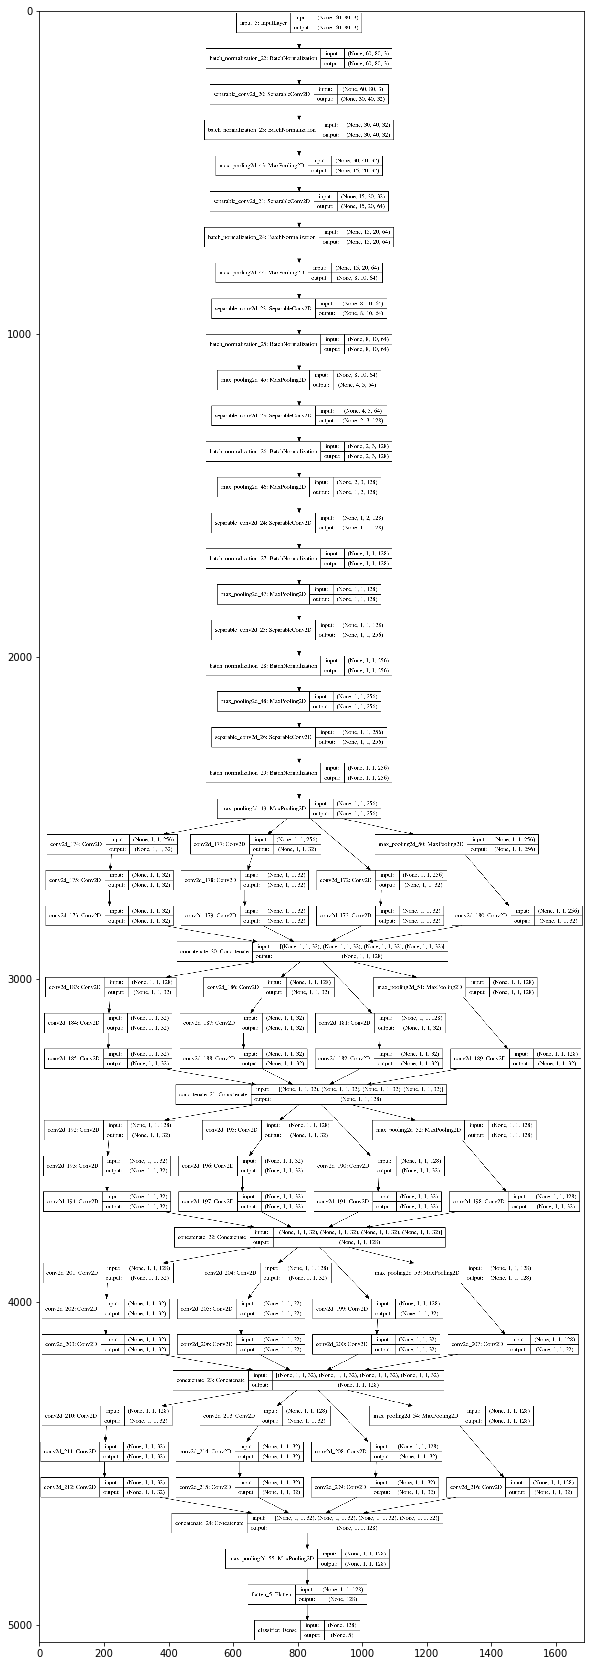

In [28]:
plot_model(tmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(30,30))
plt.imshow(plt.imread('model_plot.png'))
print("Complete")

In [29]:
opt = optimizers.SGD(lr=0.001,decay=0.0001,momentum=0.9)
history = tmodel.compile(loss='categorical_crossentropy',
                         metrics=['categorical_accuracy'],
                         optimizer=opt)
print("Compiled")

Compiled


In [30]:
best_weights = "./weights.hdf5"
checkpoint = ModelCheckpoint(
    best_weights_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=20,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)
reducelr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    min_lr=1e-4
)


callbacks = [checkpoint,tensorboard,earlystop]
print("CallBacks Ready!")

CallBacks Ready!


In [31]:
history = tmodel.fit(
    x_trn,
    y_trnHot,
    epochs = 50,
    batch_size = 32,
    validation_data = (x_test,y_testHot),
    callbacks = callbacks,
    verbose = 1
)
print("Model Trained")
print("See Training Visuals Below")

Train on 9957 samples, validate on 2487 samples
Epoch 1/50
9957/9957 [==============================] - 16s 2ms/step - loss: 1.4810 - categorical_accuracy: 0.2603 - val_loss: 1.4078 - val_categorical_accuracy: 0.2714

Epoch 00001: val_loss improved from -inf to 1.40781, saving model to ./weights.hdf5
Epoch 2/50
9957/9957 [==============================] - 14s 1ms/step - loss: 1.3802 - categorical_accuracy: 0.3133 - val_loss: 1.3923 - val_categorical_accuracy: 0.2863

Epoch 00002: val_loss did not improve from 1.40781
Epoch 3/50
9957/9957 [==============================] - 14s 1ms/step - loss: 1.1872 - categorical_accuracy: 0.4548 - val_loss: 0.9044 - val_categorical_accuracy: 0.6630

Epoch 00003: val_loss did not improve from 1.40781
Epoch 4/50
9957/9957 [==============================] - 14s 1ms/step - loss: 0.6960 - categorical_accuracy: 0.6754 - val_loss: 0.8333 - val_categorical_accuracy: 0.6884

Epoch 00004: val_loss did not improve from 1.40781
Epoch 5/50
9957/9957 [=============

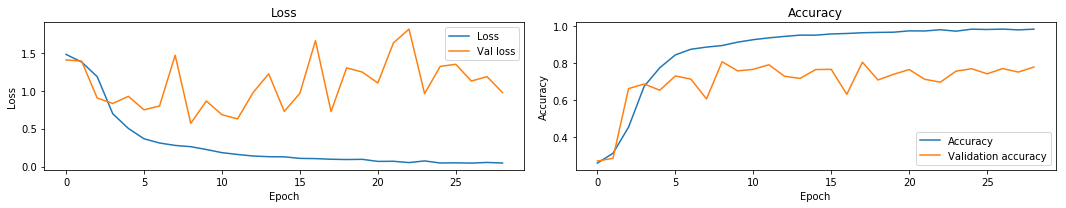

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(history.history['loss'], label="Loss")
axes[0].plot(history.history['val_loss'], label="Val loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()


axes[1].plot(history.history['categorical_accuracy'], label="Accuracy")
axes[1].plot(history.history['val_categorical_accuracy'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

In [34]:
## Loading Best Weights from model
tmodel.load_weights(best_weights)
from keras.preprocessing.image import ImageDataGenerator
trn_augs = ImageDataGenerator(featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False, zca_epsilon=1e-06,
                rotation_range=5, width_shift_range=0.0,
                height_shift_range=0.0, brightness_range=None,
                shear_range=0, zoom_range=0.0,
                channel_shift_range=0.0, fill_mode='nearest',
                cval=0.0, horizontal_flip=True, vertical_flip=True,
                rescale=None, preprocessing_function=None,
                data_format=None, validation_split=0.0)
trn_augs.fit(x_trn)
print("Best Weights From Previous Training Loaded")
print("Augmentation Complete")

Best Weights From Previous Training Loaded
Augmentation Complete


In [35]:
history = tmodel.fit_generator(trn_augs.flow(x_trn, y_trnHot, batch_size=32),
                              steps_per_epoch=64,
                              epochs=64,
                              workers=4,
                              use_multiprocessing=True,validation_data =(x_test,y_testHot),
                              callbacks=callbacks)
print("Model Trained")
print("See Training Visuals Below")

Epoch 1/64
64/64 [==============================] - 6s 92ms/step - loss: 0.1469 - categorical_accuracy: 0.9463 - val_loss: 1.1531 - val_categorical_accuracy: 0.7583

Epoch 00001: val_loss did not improve from 1.81517
Epoch 2/64
64/64 [==============================] - 5s 85ms/step - loss: 0.0933 - categorical_accuracy: 0.9697 - val_loss: 1.3306 - val_categorical_accuracy: 0.7129

Epoch 00002: val_loss did not improve from 1.81517
Epoch 3/64
64/64 [==============================] - 5s 82ms/step - loss: 0.0688 - categorical_accuracy: 0.9766 - val_loss: 1.5175 - val_categorical_accuracy: 0.7185

Epoch 00003: val_loss did not improve from 1.81517
Epoch 4/64
64/64 [==============================] - 5s 82ms/step - loss: 0.0677 - categorical_accuracy: 0.9766 - val_loss: 1.0899 - val_categorical_accuracy: 0.7728

Epoch 00004: val_loss did not improve from 1.81517
Epoch 5/64
64/64 [==============================] - 6s 87ms/step - loss: 0.1134 - categorical_accuracy: 0.9609 - val_loss: 2.1607 - 

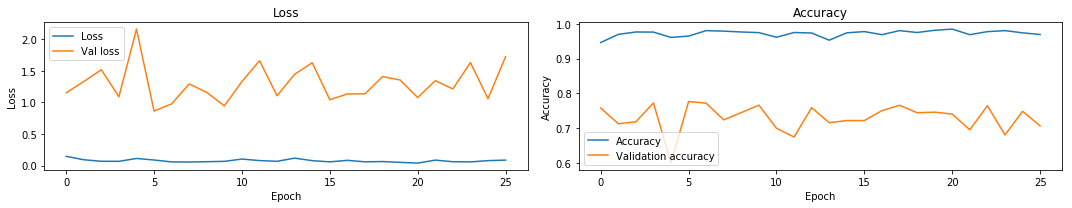

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(history.history['loss'], label="Loss")
axes[0].plot(history.history['val_loss'], label="Val loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()


axes[1].plot(history.history['categorical_accuracy'], label="Accuracy")
axes[1].plot(history.history['val_categorical_accuracy'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

In [37]:
tmodel_json = tmodel.to_json()
with open("tmodel_bloodcell.json","w") as json_file:
    json_file.write(tmodel_json)
    
tmodel.save_weights("tmodel_bloodcell.h5")

print("Tmodel: Structure And Weights Saved")

Tmodel: Structure And Weights Saved


# ~ The End!

# ~ Thank You For Viewing My Project!
# ~ Created By: Terrance Whitehurst

# ~ My Medium Deep learning Blog: https://medium.com/@TerranceWhitehurst
# ~ GitHub: https: https://github.com/Terrance-Whitehurst
# ~ LinkedIn: https://www.linkedin.com/in/terrance-whitehurst-242423173/
# ~ Kaggle: https://www.kaggle.com/twhitehurst3
# ~ Email: fifawhitehurst@gmail.com
# ~ Happy Learning!
